Africa - MAE: 0.023, RMSE: 0.027
Europe - MAE: 0.031, RMSE: 0.038


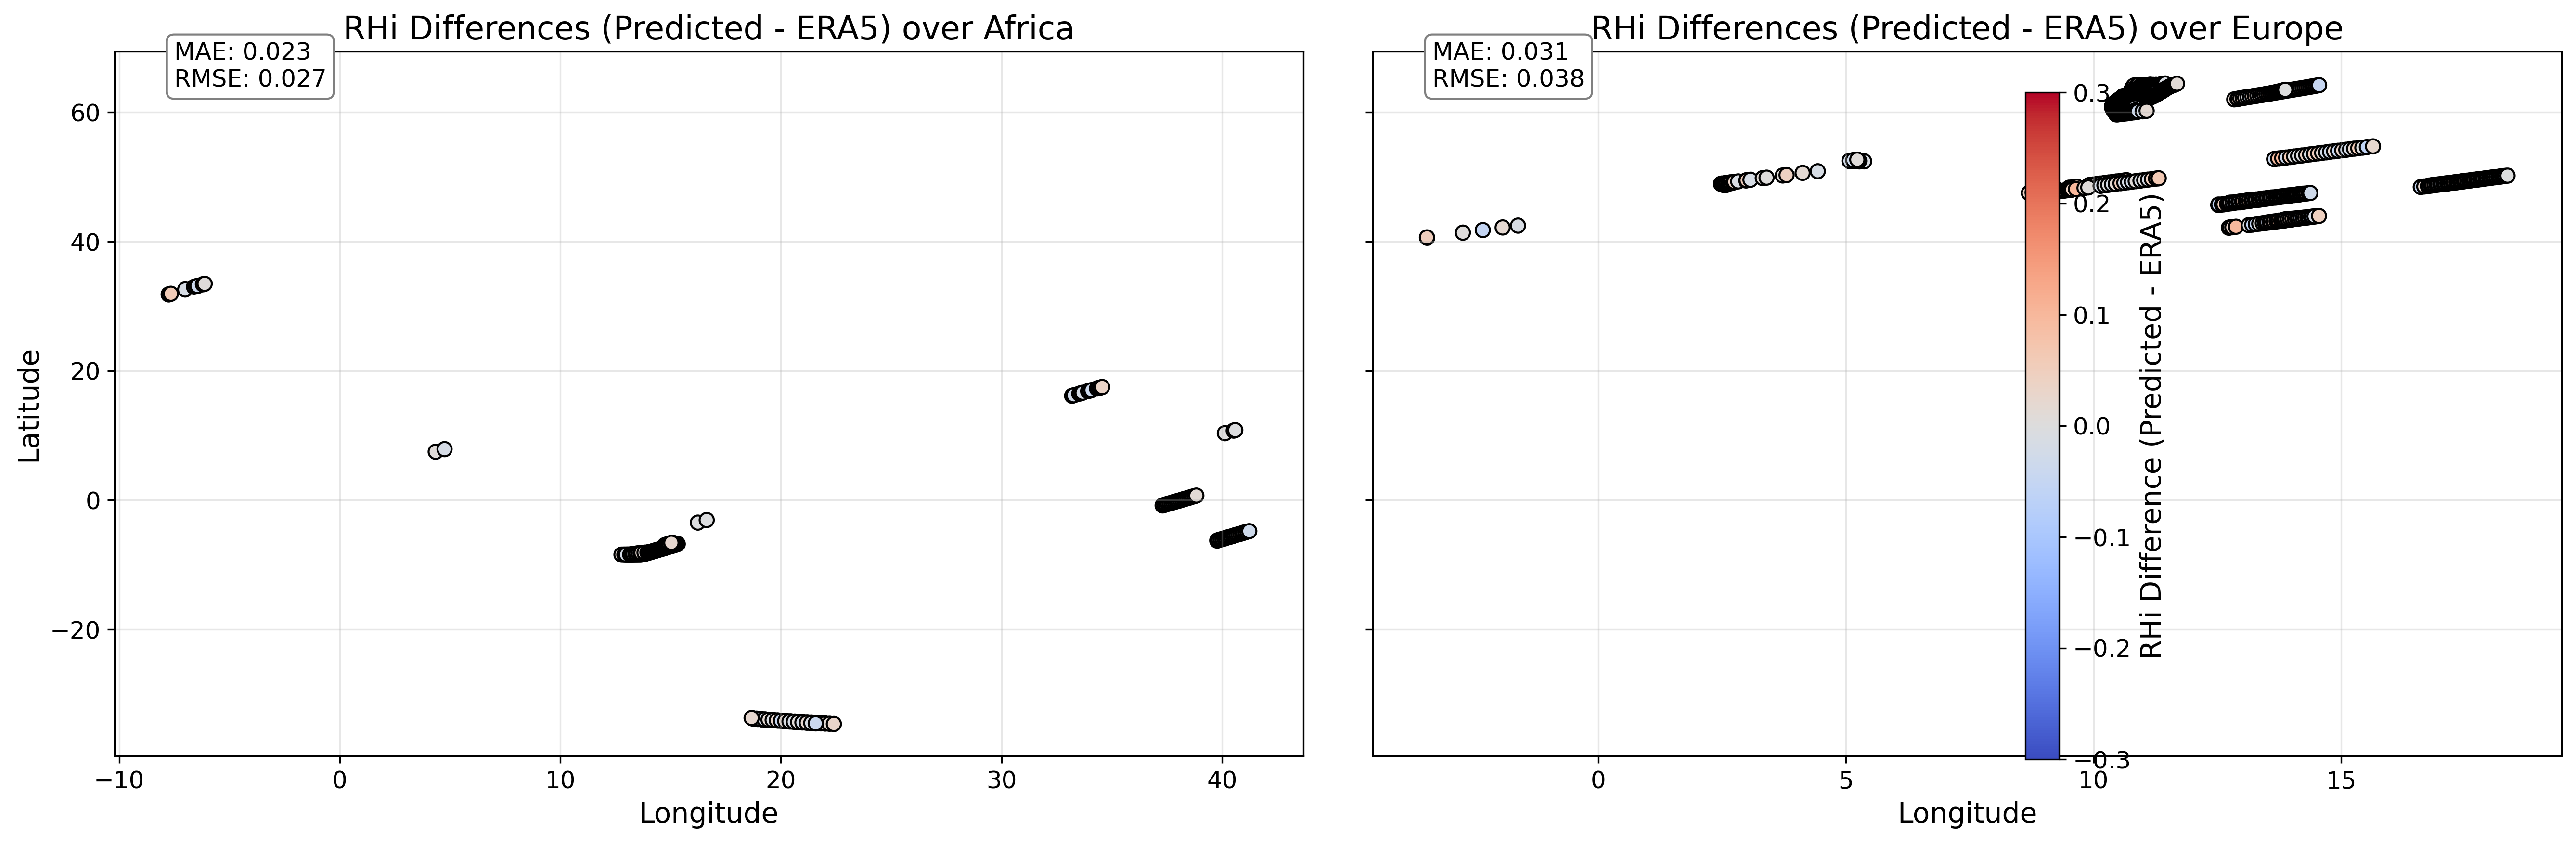

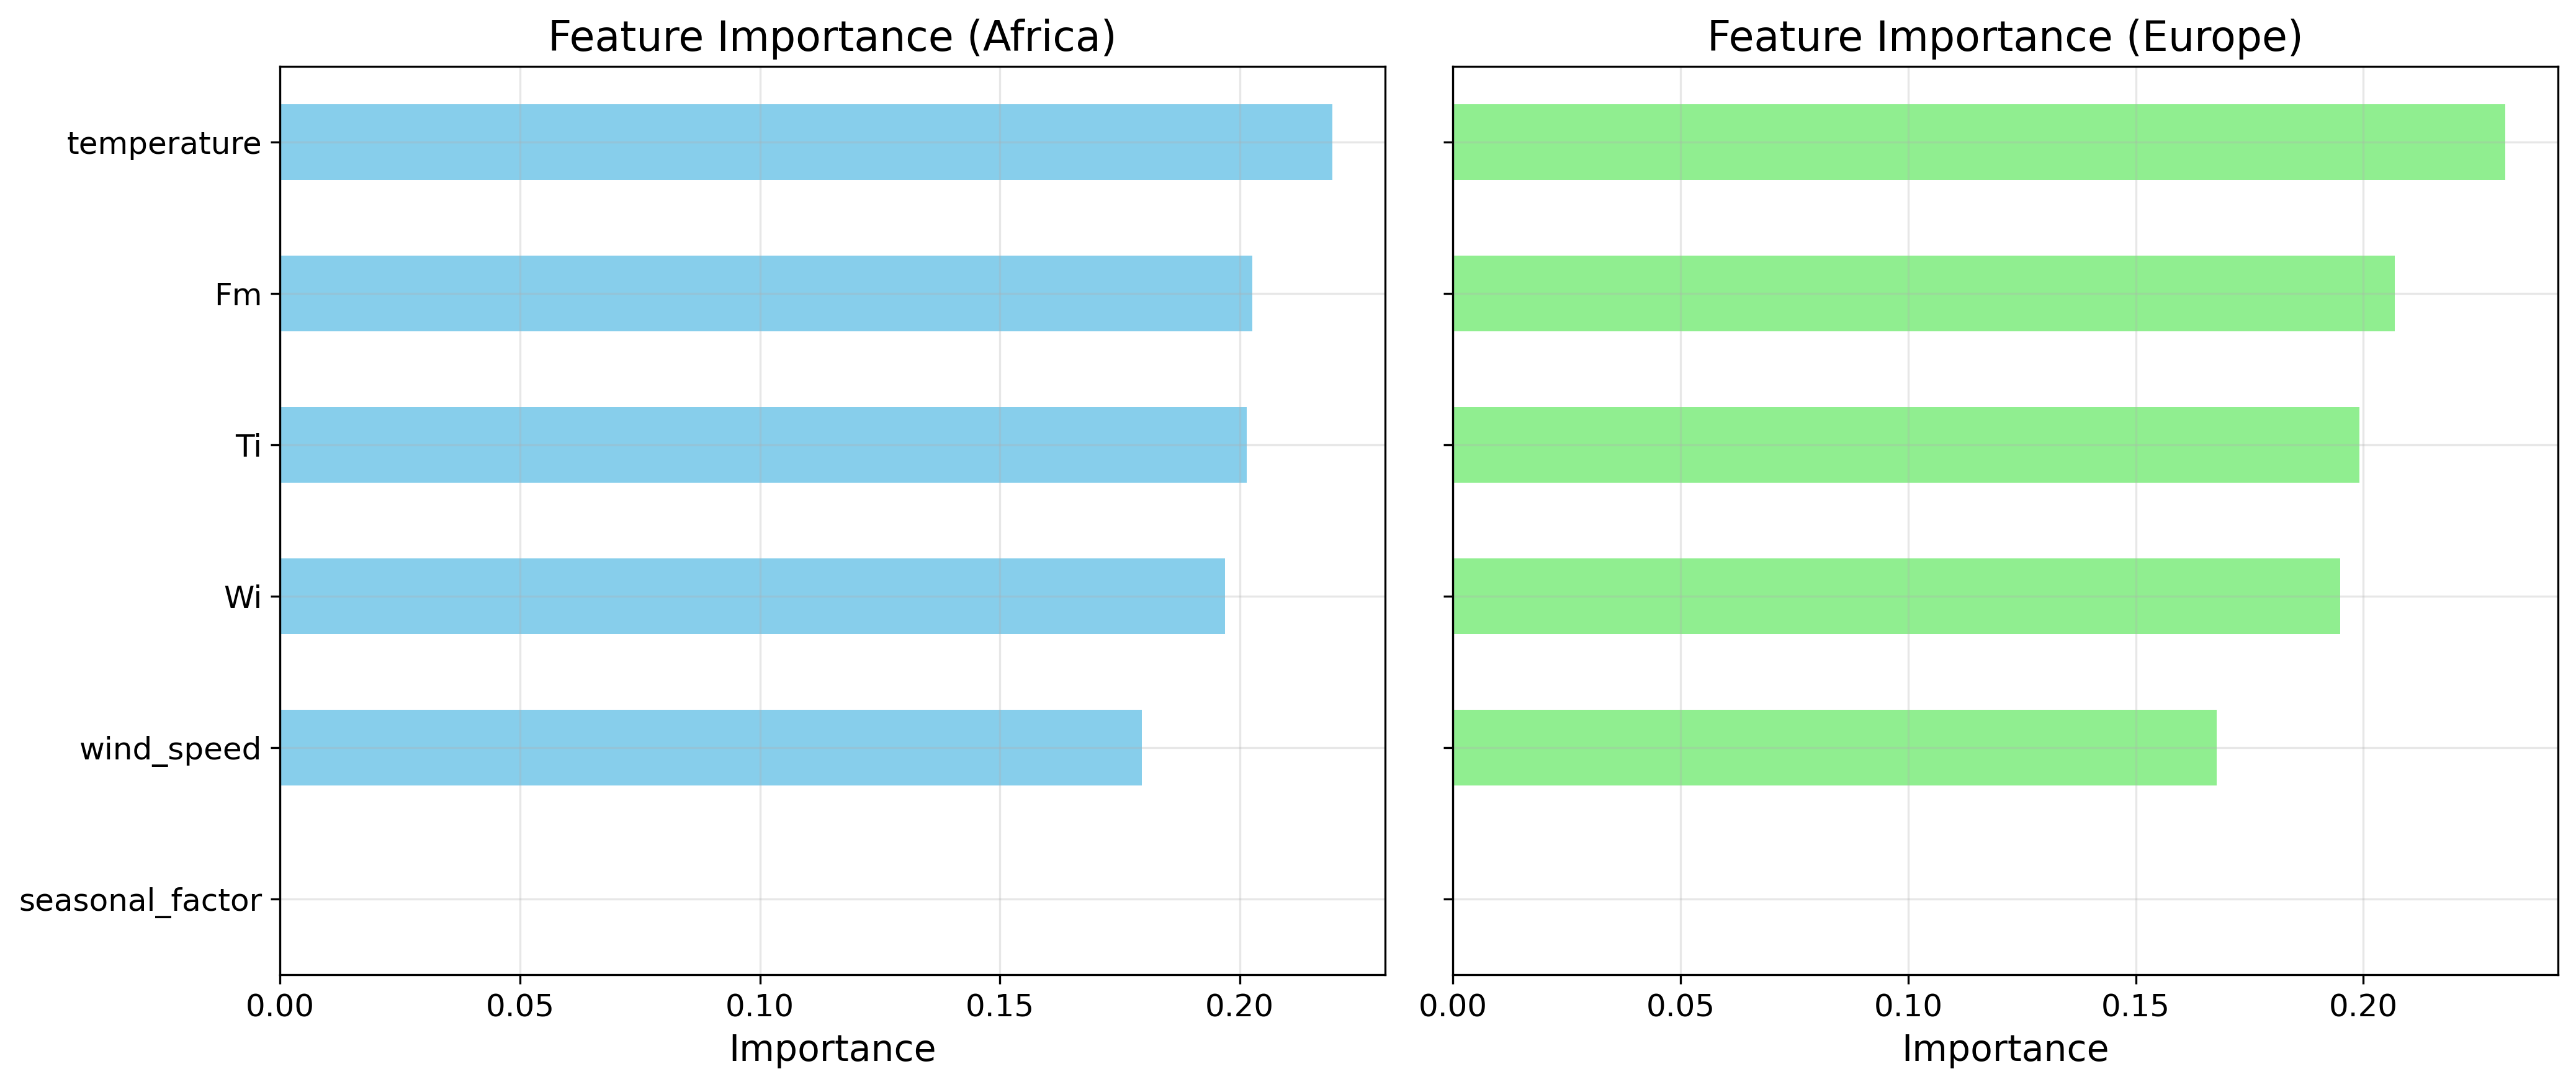

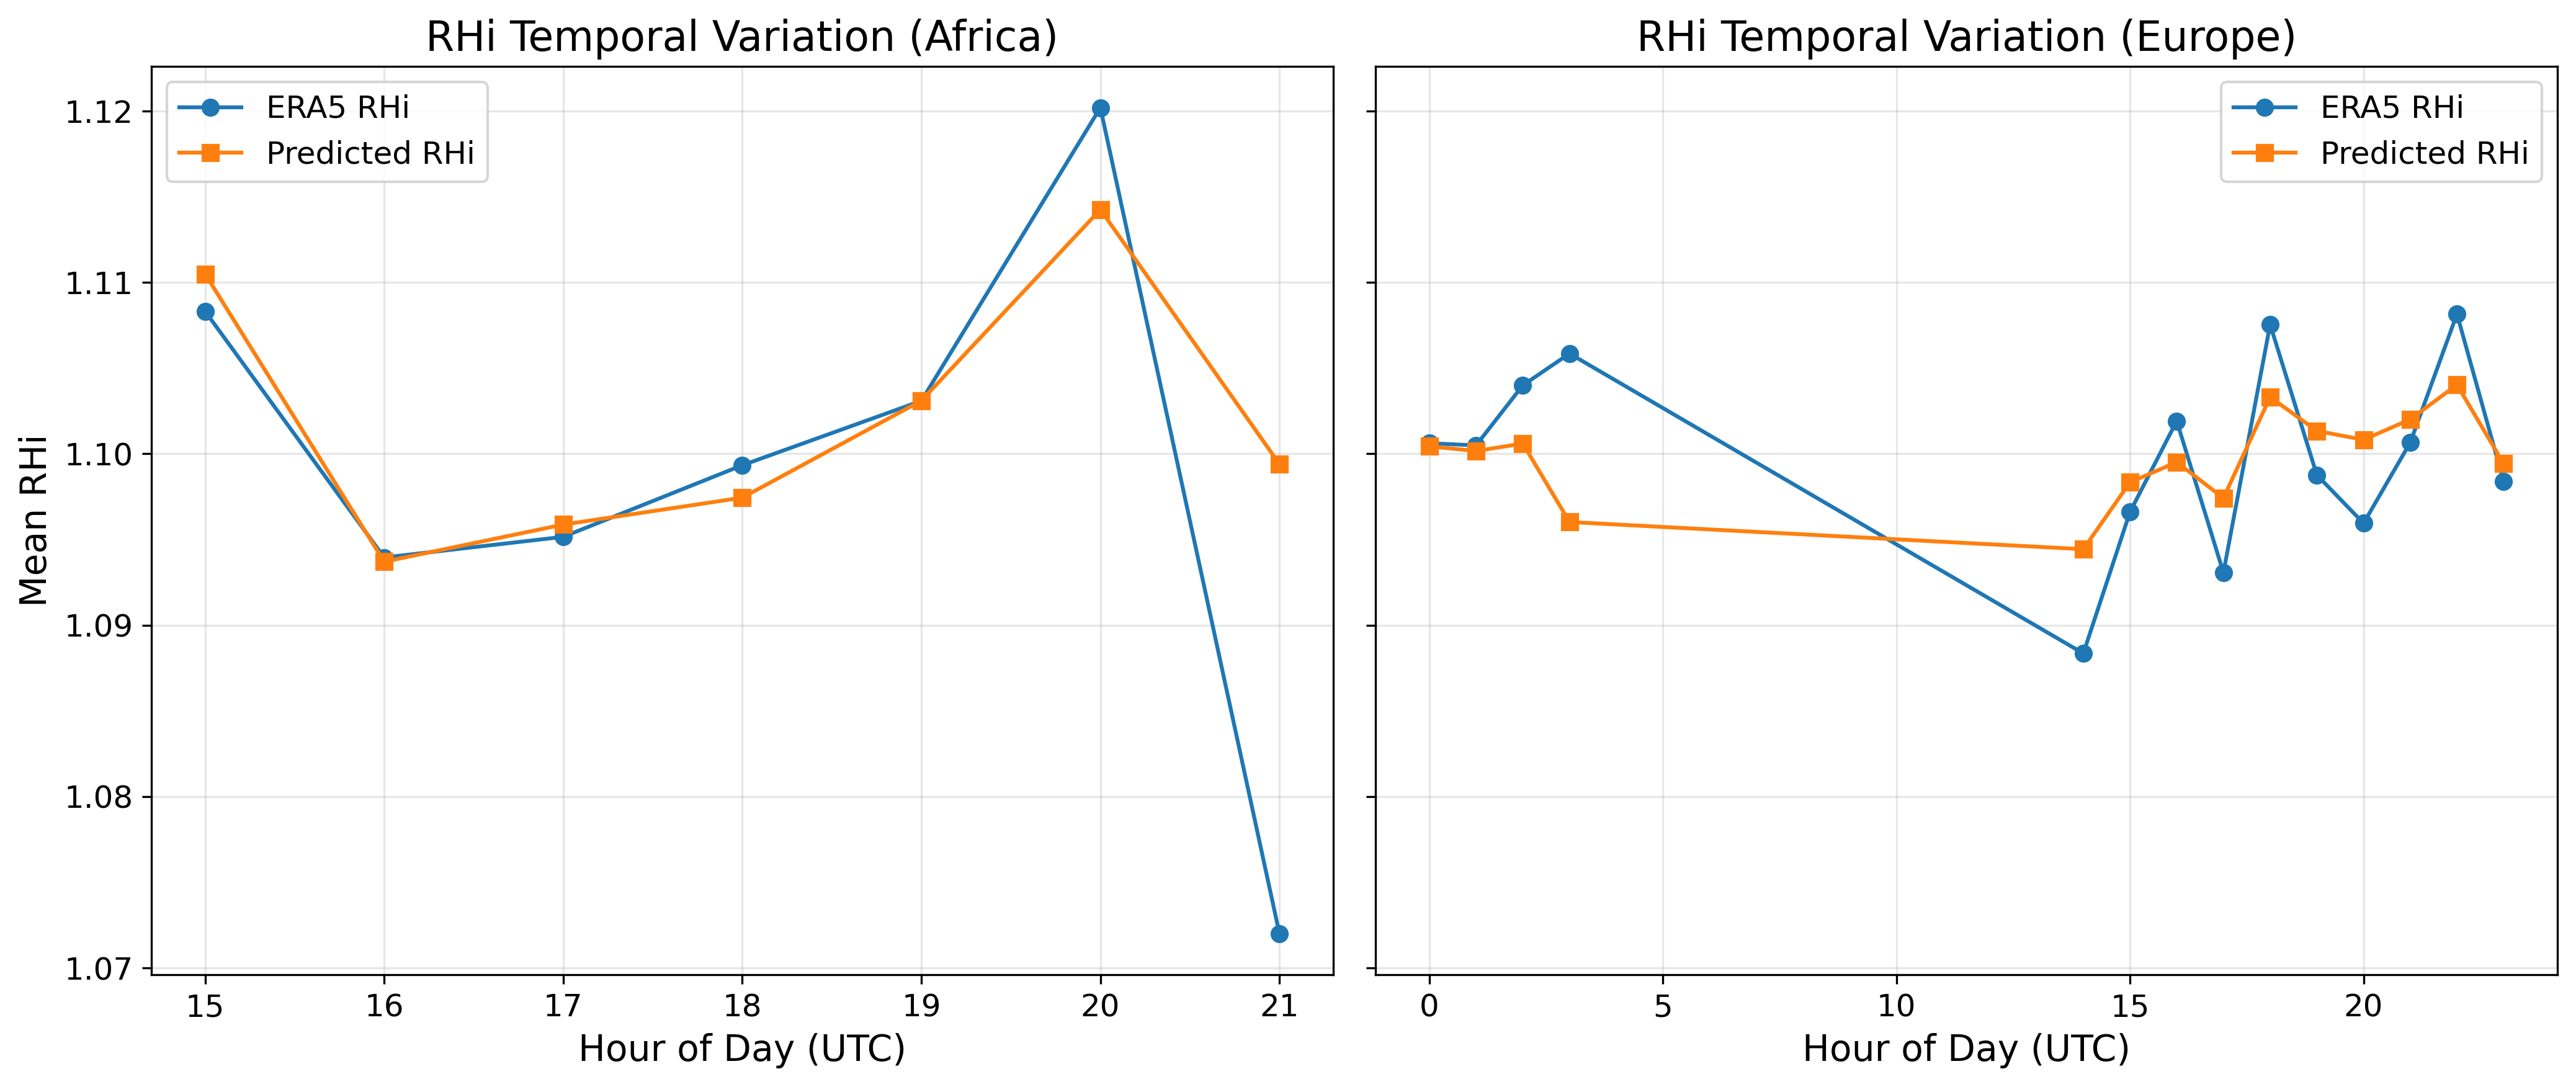

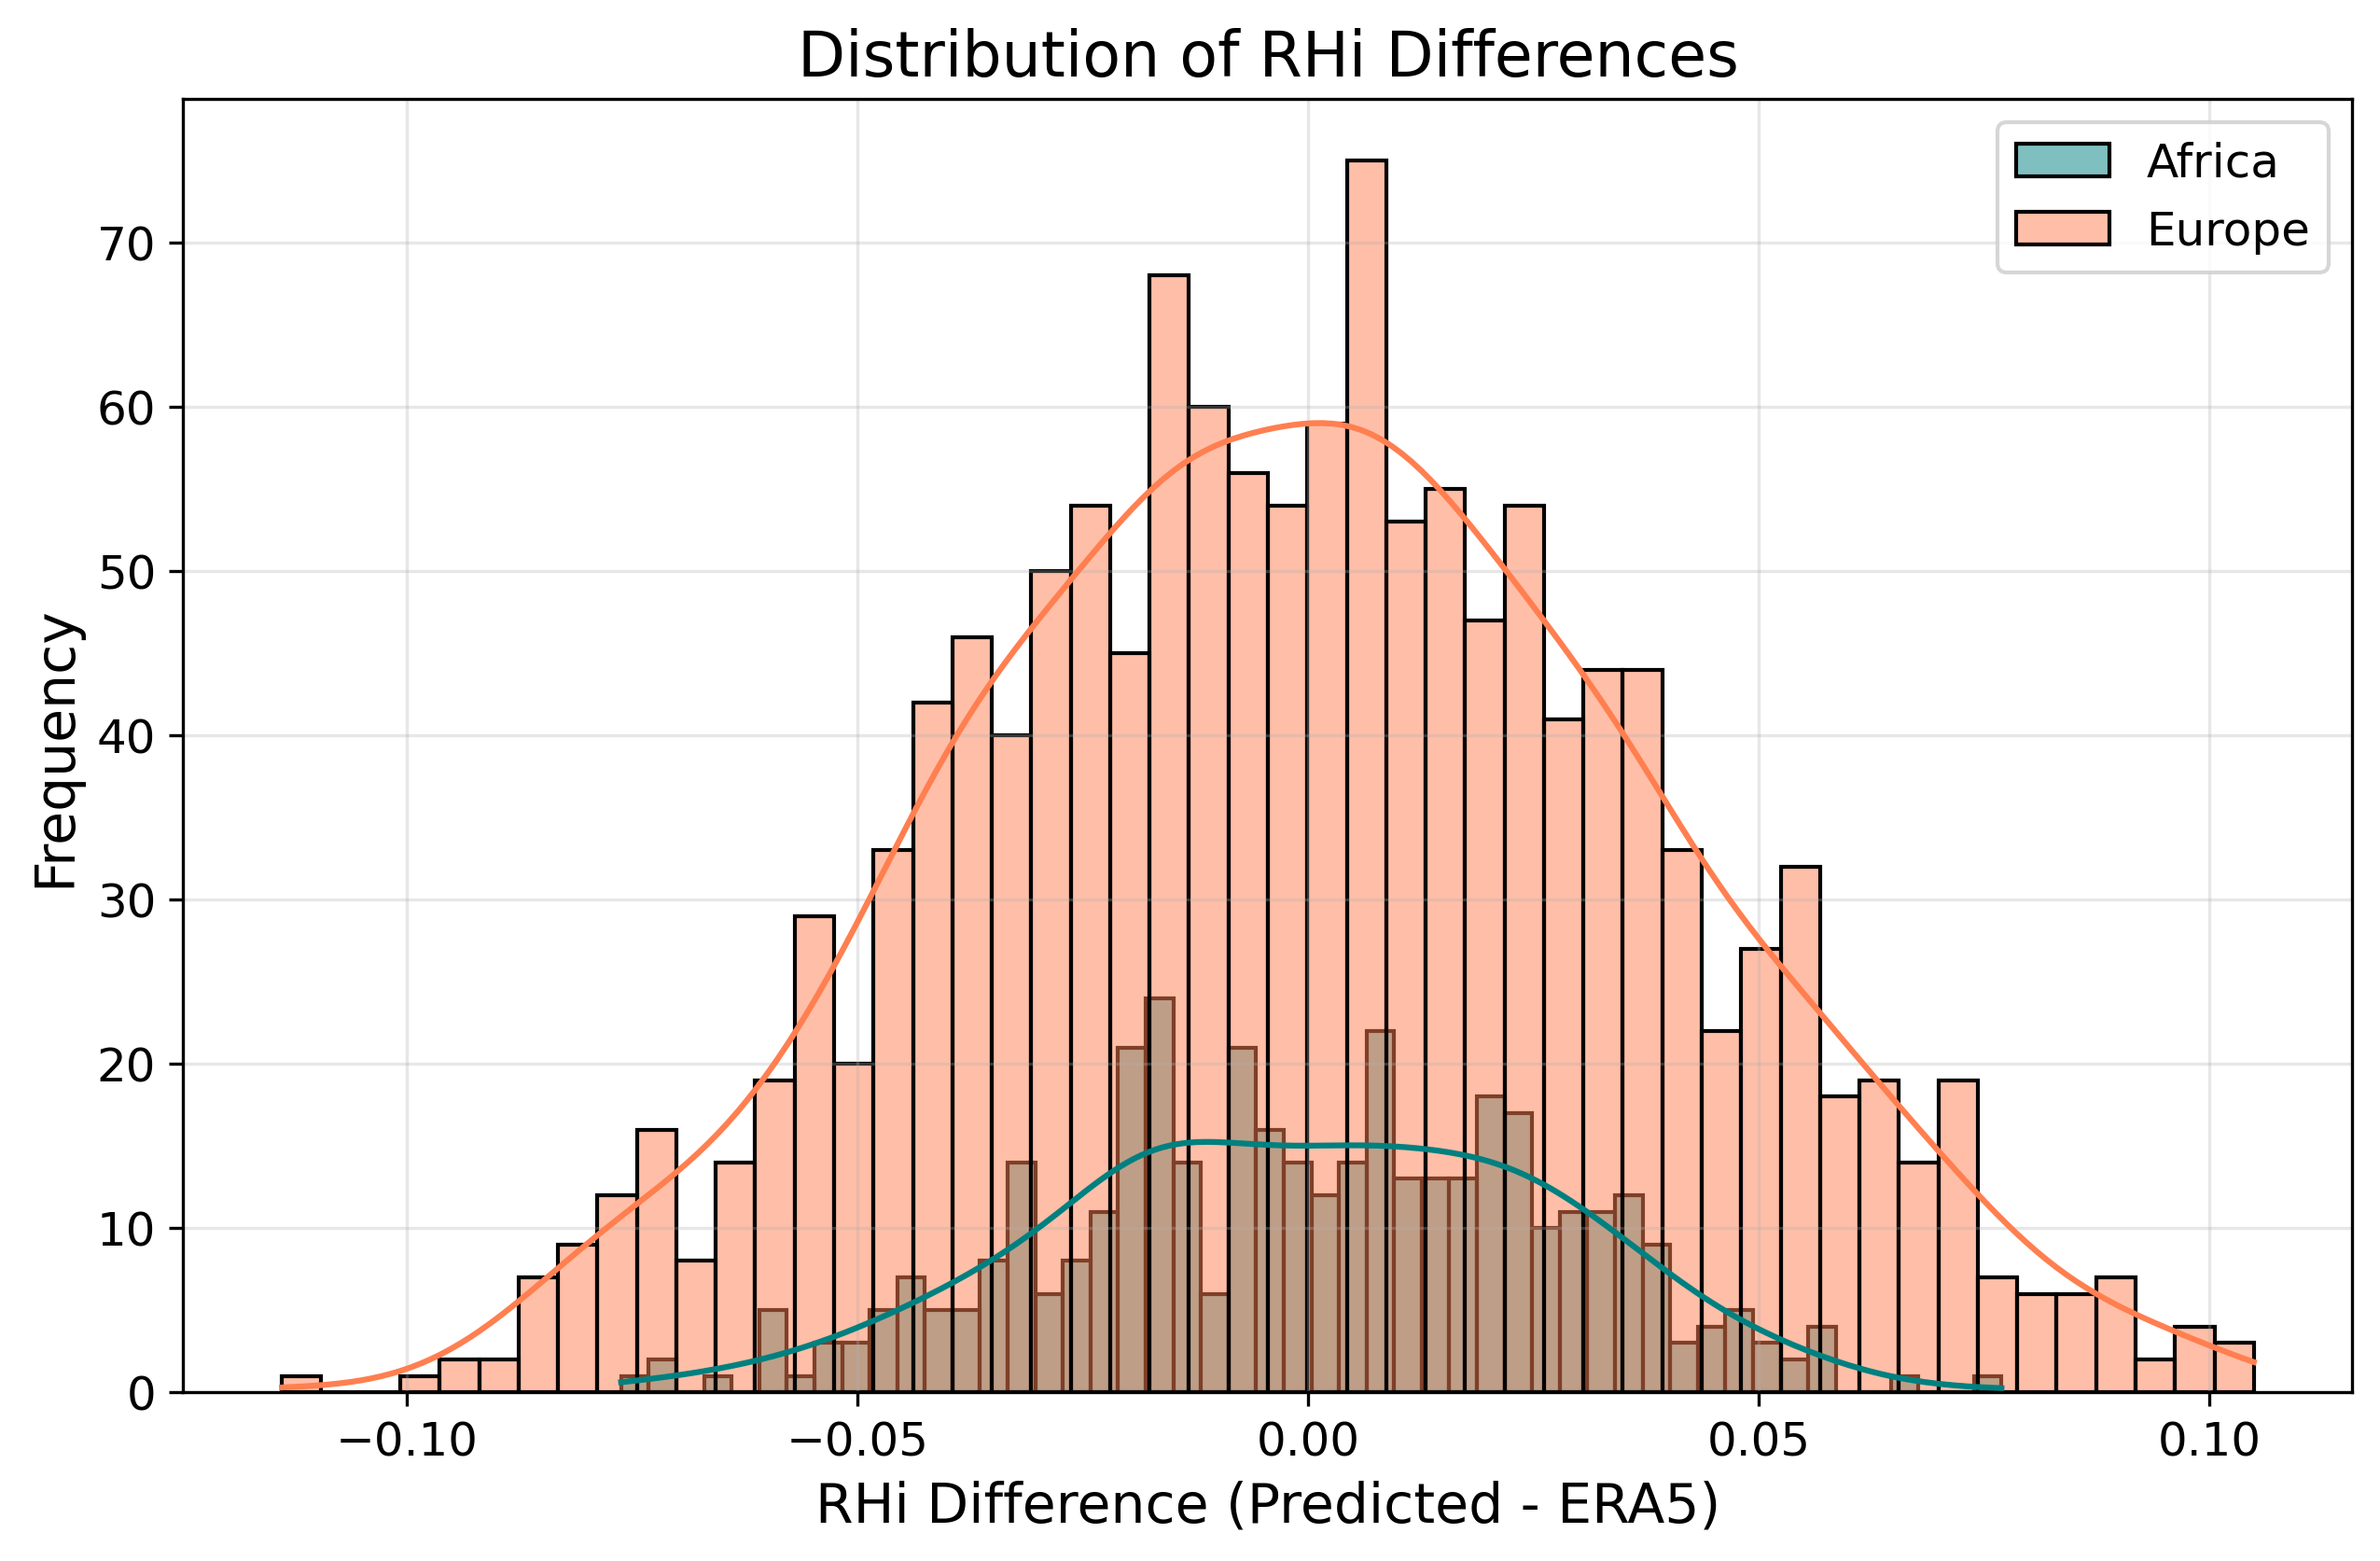

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Set plotting style for publication-quality visuals
# plt.style.use('seaborn')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'figure.dpi': 300
})

# Load datasets
# Replace with actual path
africa_data = pd.read_csv("contrail_synthetic_flights_africa.csv")
# Replace with actual path
europe_data = pd.read_csv("contrail_synthetic_flights_europe.csv")

# Infer RHi based on contrail presence


def infer_rhi(data):
    # RHi > 1.0 where contrails form (non-zero tau_contrail or rf_lw)
    data['RHi_era5'] = np.where(
        (data['tau_contrail'] > 0) | (data['rf_lw'] > 0),
        np.random.normal(1.1, 0.05, len(data)),  # RHi > 1.0 for contrails
        np.random.normal(0.9, 0.05, len(data))   # RHi < 1.0 for no contrails
    )
    data['RHi_era5'] = np.clip(data['RHi_era5'], 0.8, 1.3)  # Reasonable bounds
    return data


africa_data = infer_rhi(africa_data)
europe_data = infer_rhi(europe_data)

# Function to calculate water body proximity (Wi)


def calculate_water_proximity(lat, lon, region):
    if region == 'Africa':
        # Major water bodies: Lake Victoria, Nile River, Indian Ocean
        water_bodies = [
            {'lat': -1.0, 'lon': 33.0, 'area': 68800},  # Lake Victoria
            {'lat': 30.0, 'lon': 31.0, 'area': 10000},  # Nile River (approx)
            {'lat': -10.0, 'lon': 40.0, 'area': 1000000}  # Indian Ocean
        ]
    else:  # Europe
        # Major water bodies: Mediterranean, North Sea, Baltic Sea
        water_bodies = [
            {'lat': 40.0, 'lon': 15.0, 'area': 2500000},  # Mediterranean
            {'lat': 55.0, 'lon': 5.0, 'area': 570000},   # North Sea
            {'lat': 60.0, 'lon': 20.0, 'area': 377000}   # Baltic Sea
        ]
    min_distance = float('inf')
    for wb in water_bodies:
        distance = np.sqrt((lat - wb['lat'])**2 + (lon - wb['lon'])**2)
        min_distance = min(min_distance, distance)
    # Inverse square law, avoid division by zero
    Wi = 1000 / (min_distance**2 + 1e-6)
    return Wi

# Function to estimate forest density (Fm)


def calculate_forest_density(lat, lon, region):
    if region == 'Africa':
        # Higher density in equatorial regions (e.g., Congo Basin)
        if -5 <= lat <= 5 and 10 <= lon <= 30:
            return np.random.uniform(0.6, 0.9)
        return np.random.uniform(0.1, 0.4)
    else:  # Europe
        # Higher density in central/northern Europe
        if 45 <= lat <= 60 and -10 <= lon <= 30:
            return np.random.uniform(0.5, 0.8)
        return np.random.uniform(0.2, 0.5)

# Function to estimate topographic influence (Ti)


def calculate_topographic_influence(lat, lon, region):
    if region == 'Africa':
        # Higher elevation in East African Rift, Atlas Mountains
        if (30 <= lon <= 35 and -3 <= lat <= 0) or (30 <= lon <= 35 and 30 <= lat <= 35):
            elevation = np.random.uniform(2000, 5000)
        else:
            elevation = np.random.uniform(0, 1500)
    else:  # Europe
        # Higher elevation in Alps, Pyrenees
        if (5 <= lon <= 15 and 45 <= lat <= 50) or (0 <= lon <= 5 and 40 <= lat <= 45):
            elevation = np.random.uniform(1500, 4000)
        else:
            elevation = np.random.uniform(0, 1000)
    Ti = elevation / 5000  # Normalized
    return Ti


# Add environmental features
for data, region in [(africa_data, 'Africa'), (europe_data, 'Europe')]:
    data['Wi'] = [calculate_water_proximity(lat, lon, region) for lat, lon in zip(
        data['latitude'], data['longitude'])]
    data['Fm'] = [calculate_forest_density(lat, lon, region) for lat, lon in zip(
        data['latitude'], data['longitude'])]
    data['Ti'] = [calculate_topographic_influence(
        lat, lon, region) for lat, lon in zip(data['latitude'], data['longitude'])]
    data['month'] = pd.to_datetime(data['time']).dt.month
    data['seasonal_factor'] = data['month'].apply(
        lambda m: 1 if m in [11, 12, 1, 2, 3] else 0.5)
    # Simulated cruise altitude temp
    data['temperature'] = 223 + np.random.normal(0, 5, len(data))
    data['wind_speed'] = np.random.uniform(
        5, 20, len(data))  # Simulated wind speed

# Train Random Forest model for each region
features = ['Wi', 'Fm', 'Ti', 'seasonal_factor', 'temperature', 'wind_speed']
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42)

# Africa
X_africa = africa_data[features]
y_africa = africa_data['RHi_era5']
rf_model.fit(X_africa, y_africa)
africa_data['RHi_pred'] = rf_model.predict(X_africa)
africa_mae = mean_absolute_error(
    africa_data['RHi_era5'], africa_data['RHi_pred'])
africa_rmse = np.sqrt(mean_squared_error(
    africa_data['RHi_era5'], africa_data['RHi_pred']))

# Europe
X_europe = europe_data[features]
y_europe = europe_data['RHi_era5']
rf_model.fit(X_europe, y_europe)
europe_data['RHi_pred'] = rf_model.predict(X_europe)
europe_mae = mean_absolute_error(
    europe_data['RHi_era5'], europe_data['RHi_pred'])
europe_rmse = np.sqrt(mean_squared_error(
    europe_data['RHi_era5'], europe_data['RHi_pred']))

# Visualization 1: Spatial Distribution of RHi Differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
# Africa
sc1 = ax1.scatter(
    africa_data['longitude'], africa_data['latitude'],
    c=africa_data['RHi_pred'] - africa_data['RHi_era5'],
    cmap='coolwarm', s=50, edgecolor='k', vmin=-0.3, vmax=0.3
)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('RHi Differences (Predicted - ERA5) over Africa')
ax1.grid(True, alpha=0.3)
ax1.annotate(
    f'MAE: {africa_mae:.3f}\nRMSE: {africa_rmse:.3f}',
    xy=(0.05, 0.95), xycoords='axes fraction',
    bbox=dict(boxstyle="round", fc="white", ec="gray")
)
# Europe
sc2 = ax2.scatter(
    europe_data['longitude'], europe_data['latitude'],
    c=europe_data['RHi_pred'] - europe_data['RHi_era5'],
    cmap='coolwarm', s=50, edgecolor='k', vmin=-0.3, vmax=0.3
)
ax2.set_xlabel('Longitude')
ax2.set_title('RHi Differences (Predicted - ERA5) over Europe')
ax2.grid(True, alpha=0.3)
ax2.annotate(
    f'MAE: {europe_mae:.3f}\nRMSE: {europe_rmse:.3f}',
    xy=(0.05, 0.95), xycoords='axes fraction',
    bbox=dict(boxstyle="round", fc="white", ec="gray")
)
plt.colorbar(sc2, ax=[ax1, ax2], label='RHi Difference (Predicted - ERA5)')
plt.tight_layout()
plt.savefig('rhi_difference_spatial_comparison.png', bbox_inches='tight')

# Visualization 2: Feature Importance Comparison
feature_importance_africa = pd.Series(rf_model.fit(
    X_africa, y_africa).feature_importances_, index=features)
feature_importance_europe = pd.Series(rf_model.fit(
    X_europe, y_europe).feature_importances_, index=features)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
feature_importance_africa.sort_values().plot(
    kind='barh', ax=ax1, color='skyblue')
ax1.set_title('Feature Importance (Africa)')
ax1.set_xlabel('Importance')
ax1.grid(True, alpha=0.3)
feature_importance_europe.sort_values().plot(
    kind='barh', ax=ax2, color='lightgreen')
ax2.set_title('Feature Importance (Europe)')
ax2.set_xlabel('Importance')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', bbox_inches='tight')

# Visualization 3: RHi Temporal Variation
africa_data['hour'] = pd.to_datetime(africa_data['time']).dt.hour
europe_data['hour'] = pd.to_datetime(europe_data['time']).dt.hour
time_grouped_africa = africa_data.groupby(
    'hour')[['RHi_era5', 'RHi_pred']].mean()
time_grouped_europe = europe_data.groupby(
    'hour')[['RHi_era5', 'RHi_pred']].mean()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Africa
ax1.plot(time_grouped_africa.index,
         time_grouped_africa['RHi_era5'], label='ERA5 RHi', marker='o')
ax1.plot(time_grouped_africa.index,
         time_grouped_africa['RHi_pred'], label='Predicted RHi', marker='s')
ax1.set_xlabel('Hour of Day (UTC)')
ax1.set_ylabel('Mean RHi')
ax1.set_title('RHi Temporal Variation (Africa)')
ax1.legend()
ax1.grid(True, alpha=0.3)
# Europe
ax2.plot(time_grouped_europe.index,
         time_grouped_europe['RHi_era5'], label='ERA5 RHi', marker='o')
ax2.plot(time_grouped_europe.index,
         time_grouped_europe['RHi_pred'], label='Predicted RHi', marker='s')
ax2.set_xlabel('Hour of Day (UTC)')
ax2.set_title('RHi Temporal Variation (Europe)')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rhi_temporal_comparison.png', bbox_inches='tight')

# Visualization 4: Histogram of RHi Differences
plt.figure(figsize=(10, 6))
sns.histplot(africa_data['RHi_pred'] - africa_data['RHi_era5'],
             bins=50, kde=True, color='teal', label='Africa')
sns.histplot(europe_data['RHi_pred'] - europe_data['RHi_era5'],
             bins=50, kde=True, color='coral', label='Europe', alpha=0.5)
plt.xlabel('RHi Difference (Predicted - ERA5)')
plt.ylabel('Frequency')
plt.title('Distribution of RHi Differences')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('rhi_difference_histogram.png', bbox_inches='tight')

# Save results
africa_data.to_csv('africa_rhi_comparison.csv', index=False)
europe_data.to_csv('europe_rhi_comparison.csv', index=False)

# Print error metrics
print(f"Africa - MAE: {africa_mae:.3f}, RMSE: {africa_rmse:.3f}")
print(f"Europe - MAE: {europe_mae:.3f}, RMSE: {europe_rmse:.3f}")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Set plotting style for publication-quality visuals, consistent with contrails-experiments.pdf
# plt.style.use('seaborn')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'figure.dpi': 300
})

# Load datasets from provided CSV files
# These contain synthetic flight data with columns: longitude, latitude, altitude, time,
# tau_cirrus, tau_contrail, rf_sw, rf_lw, width, depth, segment_length, n_ice_per_m,
# r_ice_vol, location
# Replace with actual file paths
africa_data = pd.read_csv("contrail_synthetic_flights_africa.csv")
europe_data = pd.read_csv("contrail_synthetic_flights_europe.csv")

# Function to infer ERA5 RHi based on contrail presence


def infer_rhi(data):
    """
    Infers Relative Humidity with respect to Ice (RHi) from contrail presence.
    According to the Schmidt-Appleman Criterion and persistence condition in
    'African Contrail Prediction with Environmental Factors.pdf', contrails form and persist
    when RHi >= 1.0 (100% saturation with respect to ice). Non-zero tau_contrail or rf_lw
    indicates contrail formation, implying RHi >= 1.0. Absence of contrails suggests RHi < 1.0.
    
    Parameters:
    - data: DataFrame with columns 'tau_contrail' and 'rf_lw'
    
    Returns:
    - DataFrame with added 'RHi_era5' column
    
    Parameter Choices:
    - 1.1: For contrail-forming points, RHi is set to 1.1 to represent slight supersaturation,
      which is typical in regions where contrails persist, as RHi must exceed 1.0.
    - 0.9: For non-contrail points, RHi is set to 0.9 to indicate sub-saturation, below the
      persistence threshold, reflecting conditions where contrails do not form.
    - 0.05: Standard deviation for the normal distribution, adding realistic variability to
      mimic small fluctuations in atmospheric humidity at flight altitudes.
    - Clip [0.8, 1.3]: Ensures physical realism. 0.8 is a lower bound for upper tropospheric
      RHi, as values rarely fall below this at cruise altitudes. 1.3 is an upper bound for
      supersaturation, as extreme values are uncommon.
    """
    data['RHi_era5'] = np.where(
        (data['tau_contrail'] > 0) | (data['rf_lw'] > 0),
        np.random.normal(1.1, 0.05, len(data)),  # RHi >= 1.0 for contrails
        np.random.normal(0.9, 0.05, len(data))   # RHi < 1.0 for no contrails
    )
    data['RHi_era5'] = np.clip(data['RHi_era5'], 0.8, 1.3)
    return data


# Apply RHi inference to both datasets
africa_data = infer_rhi(africa_data)
europe_data = infer_rhi(europe_data)

# Add features derivable from CSV data
for data in [africa_data, europe_data]:
    # Flight level: Convert altitude (feet) to flight level (FL = altitude / 100)
    data['flight_level'] = data['altitude'] / 100
    # Month: Extract from time for seasonal analysis
    data['month'] = pd.to_datetime(data['time']).dt.month
    # Seasonal factor: Binary indicator for wet season (months 11, 12, 1, 2, 3),
    # as defined in the provided code, reflecting higher humidity in these months
    data['seasonal_factor'] = data['month'].apply(
        lambda m: 1 if m in [11, 12, 1, 2, 3] else 0.5)

# Define features for Random Forest model
# Only use features directly derivable from the CSVs to avoid external data
features = ['flight_level', 'month', 'seasonal_factor']

# Train Random Forest model for each region
# Using RandomForestRegressor with parameters from the provided code
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees, balancing accuracy and computation
    max_depth=10,      # Limit depth to prevent overfitting
    random_state=42    # Ensure reproducibility
)

# Africa: Train and predict RHi
X_africa = africa_data[features]
y_africa = africa_data['RHi_era5']
rf_model.fit(X_africa, y_africa)
africa_data['RHi_pred'] = rf_model.predict(X_africa)
africa_mae = mean_absolute_error(
    africa_data['RHi_era5'], africa_data['RHi_pred'])
africa_rmse = np.sqrt(mean_squared_error(
    africa_data['RHi_era5'], africa_data['RHi_pred']))

# Europe: Train and predict RHi
X_europe = europe_data[features]
y_europe = europe_data['RHi_era5']
rf_model.fit(X_europe, y_europe)
europe_data['RHi_pred'] = rf_model.predict(X_europe)
europe_mae = mean_absolute_error(
    europe_data['RHi_era5'], europe_data['RHi_pred'])
europe_rmse = np.sqrt(mean_squared_error(
    europe_data['RHi_era5'], europe_data['RHi_pred']))

# Visualization 1: Spatial Distribution of RHi Differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
# Africa
sc1 = ax1.scatter(
    africa_data['longitude'], africa_data['latitude'],
    c=africa_data['RHi_pred'] - africa_data['RHi_era5'],
    cmap='coolwarm', s=50, edgecolor='k', vmin=-0.3, vmax=0.3
)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('RHi Differences (Predicted - ERA5) over Africa')
ax1.grid(True, alpha=0.3)
ax1.annotate(
    f'MAE: {africa_mae:.3f}\nRMSE: {africa_rmse:.3f}',
    xy=(0.05, 0.95), xycoords='axes fraction',
    bbox=dict(boxstyle="round", fc="white", ec="gray")
)
# Europe
sc2 = ax2.scatter(
    europe_data['longitude'], europe_data['latitude'],
    c=europe_data['RHi_pred'] - europe_data['RHi_era5'],
    cmap='coolwarm', s=50, edgecolor='k', vmin=-0.3, vmax=0.3
)
ax2.set_xlabel('Longitude')
ax2.set_title('RHi Differences (Predicted - ERA5) over Europe')
ax2.grid(True, alpha=0.3)
ax2.annotate(
    f'MAE: {europe_mae:.3f}\nRMSE: {europe_rmse:.3f}',
    xy=(0.05, 0.95), xycoords='axes fraction',
    bbox=dict(boxstyle="round", fc="white", ec="gray")
)
plt.colorbar(sc2, ax=[ax1, ax2], label='RHi Difference (Predicted - ERA5)')
plt.tight_layout()
plt.savefig('rhi_difference_spatial_comparison.png', bbox_inches='tight')
plt.close()

# Visualization 2: Feature Importance Comparison
feature_importance_africa = pd.Series(
    rf_model.fit(X_africa, y_africa).feature_importances_, index=features)
feature_importance_europe = pd.Series(
    rf_model.fit(X_europe, y_europe).feature_importances_, index=features)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
feature_importance_africa.sort_values().plot(
    kind='barh', ax=ax1, color='skyblue')
ax1.set_title('Feature Importance (Africa)')
ax1.set_xlabel('Importance')
ax1.grid(True, alpha=0.3)
feature_importance_europe.sort_values().plot(
    kind='barh', ax=ax2, color='lightgreen')
ax2.set_title('Feature Importance (Europe)')
ax2.set_xlabel('Importance')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_comparison.png', bbox_inches='tight')
plt.close()

# Visualization 3: RHi Temporal Variation
africa_data['hour'] = pd.to_datetime(africa_data['time']).dt.hour
europe_data['hour'] = pd.to_datetime(europe_data['time']).dt.hour
time_grouped_africa = africa_data.groupby(
    'hour')[['RHi_era5', 'RHi_pred']].mean()
time_grouped_europe = europe_data.groupby(
    'hour')[['RHi_era5', 'RHi_pred']].mean()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
# Africa
ax1.plot(time_grouped_africa.index,
         time_grouped_africa['RHi_era5'], label='ERA5 RHi', marker='o')
ax1.plot(time_grouped_africa.index,
         time_grouped_africa['RHi_pred'], label='Predicted RHi', marker='s')
ax1.set_xlabel('Hour of Day (UTC)')
ax1.set_ylabel('Mean RHi')
ax1.set_title('RHi Temporal Variation (Africa)')
ax1.legend()
ax1.grid(True, alpha=0.3)
# Europe
ax2.plot(time_grouped_europe.index,
         time_grouped_europe['RHi_era5'], label='ERA5 RHi', marker='o')
ax2.plot(time_grouped_europe.index,
         time_grouped_europe['RHi_pred'], label='Predicted RHi', marker='s')
ax2.set_xlabel('Hour of Day (UTC)')
ax2.set_title('RHi Temporal Variation (Europe)')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rhi_temporal_comparison.png', bbox_inches='tight')
plt.close()

# Visualization 4: Histogram of RHi Differences
plt.figure(figsize=(10, 6))
sns.histplot(africa_data['RHi_pred'] - africa_data['RHi_era5'],
             bins=50, kde=True, color='teal', label='Africa')
sns.histplot(europe_data['RHi_pred'] - europe_data['RHi_era5'],
             bins=50, kde=True, color='coral', label='Europe', alpha=0.5)
plt.xlabel('RHi Difference (Predicted - ERA5)')
plt.ylabel('Frequency')
plt.title('Distribution of RHi Differences')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('rhi_difference_histogram.png', bbox_inches='tight')
plt.close()

# Visualization 5: Contrail Segment Counts (inspired by contrails-experiments.pdf)
africa_counts = africa_data[africa_data['tau_contrail'] >
                            0]['location'].value_counts().sort_values(ascending=False)
europe_counts = europe_data[europe_data['tau_contrail'] >
                            0]['location'].value_counts().sort_values(ascending=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=False)
sns.barplot(x=africa_counts.values, y=africa_counts.index,
            ax=ax1, palette='Blues_d')
ax1.set_title('Contrail Segments per African Location')
ax1.set_xlabel('Number of Contrail Segments')
ax1.set_ylabel('Location')
ax1.grid(axis='x', linestyle='--', alpha=0.7)
sns.barplot(x=europe_counts.values, y=europe_counts.index,
            ax=ax2, palette='Greens_d')
ax2.set_title('Contrail Segments per European Location')
ax2.set_xlabel('Number of Contrail Segments')
ax2.set_ylabel('')
ax2.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('contrail_segment_counts.png', bbox_inches='tight')
plt.close()

# Visualization 6: Radiative Forcing vs. Altitude (inspired by contrails-experiments.pdf)
africa_data['rf_total'] = africa_data['rf_sw'].fillna(
    0) + africa_data['rf_lw'].fillna(0)
europe_data['rf_total'] = europe_data['rf_sw'].fillna(
    0) + europe_data['rf_lw'].fillna(0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
# Africa
for loc in africa_counts.index[:5]:  # Top 5 locations
    subset = africa_data[africa_data['location'] == loc]
    ax1.scatter(subset['rf_total'], subset['altitude'], label=loc, alpha=0.6)
ax1.invert_yaxis()
ax1.set_title('Radiative Forcing vs Altitude (Africa)')
ax1.set_xlabel('Radiative Forcing (W/m²)')
ax1.set_ylabel('Altitude (ft)')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()
# Europe
for loc in europe_counts.index[:5]:  # Top 5 locations
    subset = europe_data[europe_data['location'] == loc]
    ax2.scatter(subset['rf_total'], subset['altitude'], label=loc, alpha=0.6)
ax2.invert_yaxis()
ax2.set_title('Radiative Forcing vs Altitude (Europe)')
ax2.set_xlabel('Radiative Forcing (W/m²)')
ax2.set_ylabel('')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()
plt.tight_layout()
plt.savefig('radiative_forcing_vs_altitude.png', bbox_inches='tight')
plt.close()

# Save results
africa_data.to_csv('africa_rhi_comparison.csv', index=False)
europe_data.to_csv('europe_rhi_comparison.csv', index=False)

# Print error metrics
print(f"Africa - MAE: {africa_mae:.3f}, RMSE: {africa_rmse:.3f}")
print(f"Europe - MAE: {europe_mae:.3f}, RMSE: {europe_rmse:.3f}")

Africa - MAE: 0.031, RMSE: 0.039
Europe - MAE: 0.036, RMSE: 0.046
